<a href="https://colab.research.google.com/github/InfiniteAmmo1000/solubilityprediction/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualization of Stochastic Equations

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

#Dataset

In [ ]:
class LinearDataset(Dataset):
  #y = mx + n
  #m is slope
  #n is offset
  slope = 2.0
  offset = 0.0
  nsamples = 1500

  #random number generator for dataset
  rnd_gen_data = torch.Generator().manual_seed(1)

  def __getitem__(self, idx):
    x = torch.FloatTensor(1,).uniform_(-0.5, 0.5, generator=self.rnd_gen_data)
    y = self.slope * x + self.offset
    noise = torch.FloatTensor(1).uniform_(-0.1, 0.1, generator=self.rnd_gen_data)
    return (x, y + noise)

  def __len__(self):
    return self.nsamples

In [ ]:
train_set = LinearDataset()

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=False,
    drop_last=True
)

In [ ]:
#check how batches look
for x, y in train_loader:
  print(x.shape, y.shape)

torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])


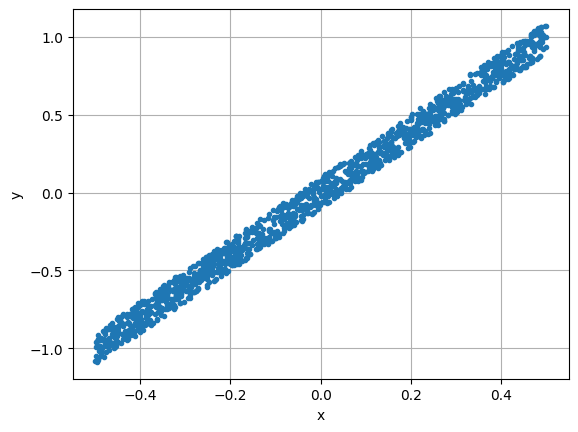

In [ ]:
x_plot = []
y_plot = []

for x, y in train_loader:
  x_plot.append(x)
  y_plot.append(y)

x_plot = torch.stack(x_plot, dim=1).flatten()
y_plot = torch.stack(y_plot, dim=1).flatten()

plt.plot(x_plot, y_plot, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

#Defining model, loss function, and optimizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps_device' #if torch.backends.mps.is_available() else 'cpu'

In [ ]:
#model.m * input + model.n

In [ ]:
#select model
#linear model(x) m x + n
model = torch.nn.Linear(1, 1, device=device)

#select loss function
loss_fn = torch.nn.MSELoss()

#select optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

#Training

In [ ]:
def log(model, loss):
#utility function for plotting
  return(model.weight.item(),
         model.bias.item(),
         loss.item()
  )

In [ ]:
num_epochs = 10
history = []

for epoch in range(num_epochs):
  #set a seed at each epoch to generate same set of random x at all times
  train_set.rnd_gen_data.manual_seed(1)
  for x, y in train_loader:
    optimizer.zero_grad()
    y_hat = model(x.to(device))
    loss = loss_fn(y_hat, y.to(device))
    history.append(log(model, loss))
    loss.backward()
    optimizer.step()

#Plots

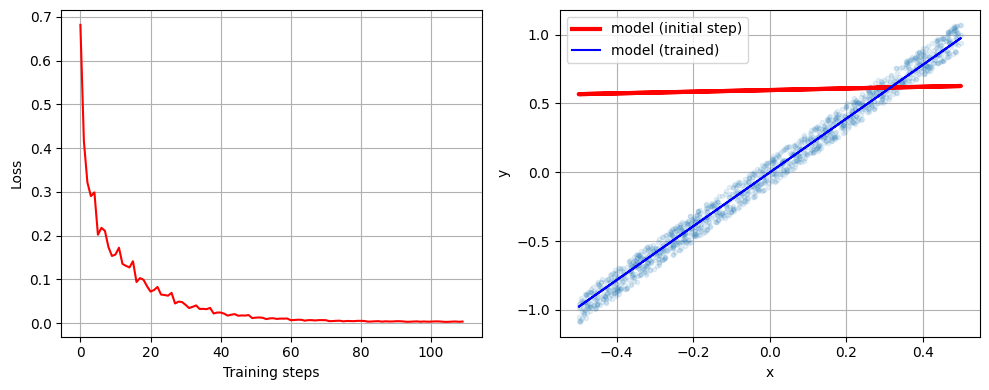

In [ ]:
slope_hist = np.array(history)[:,0]
offset_hist = np.array(history)[:,1]
loss_hist = np.array(history)[:,2]

matplotlib.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
plt.plot(loss_hist, 'r-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_plot, y_plot, '.', alpha=0.1)
plt.plot(x_plot, slope_hist[0] * x_plot + offset_hist[0], 'r-', label='model (initial step)', lw=3)
plt.plot(x_plot, slope_hist[-1] * x_plot + offset_hist[-1], 'b-', label='model (trained)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

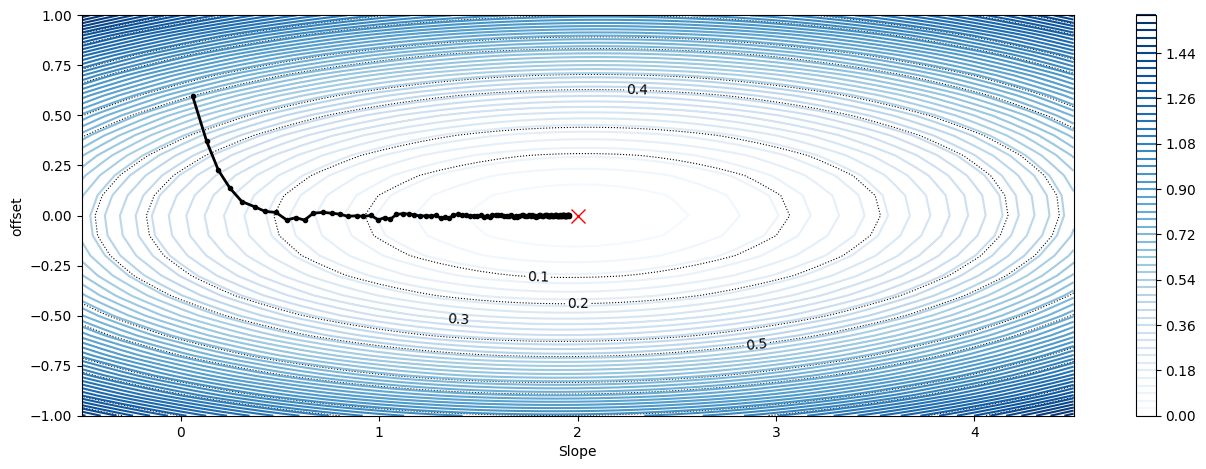

In [ ]:
def loss_function_field(m, n, xref, yref):
  '''Utility function for plotting the loss'''
  return np.mean(np.square(yref - m * xref - n))

_m = np.arange(-0.5, 4.51, 0.1)
_n = np.arange(-1., 1.01, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
  for j in range(M.shape[1]):
    Z[i, j] = loss_function_field(M[i, j], N[i, j], x_plot.numpy(), y_plot.numpy())

matplotlib.rcParams['figure.figsize'] = (16.0, 5.2)

cp = plt.contour(M, N, Z, 16, vmin=Z.min(), vmax=Z.max(), alpha=0.99, colors='k', linestyles=':', linewidths=0.8)
plt.contour(M, N, Z, 60, vmin=Z.min(), vmax=Z.max(), cmap='Blues')
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot([train_set.slope], [train_set.offset], 'rx', ms=10)
plt.plot(slope_hist, offset_hist, '.-', lw=2, c='k')
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)